# Discrete Fourier Transform (DFT), in Practice

This notebook will guide you through some basic usage of the Fourier Transform, in practice.

The objectives are:
1. Introduce the Short-time Fourier Transform (STFT).
2. Investigate what effect the different STFT parameters have on the resulting spectrogram.
3. Allow you to play around with the parameters on your own.

First, we will import the packages we need.

In [1]:
import scipy.signal as signal
import scipy.io.wavfile
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

## Create a basic sine wave

First, we will create a very basic sine wave in an array, and view it.

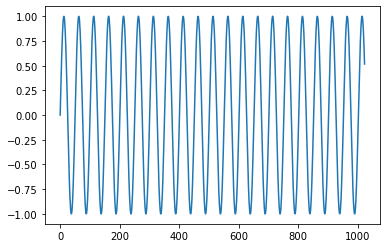

In [2]:
# Function to generate a sine wave
def generate_sine_wave(N, sr, freq):
    """
    Generate a sine wave with the given number of samples, sample-rate, and frequency.
    
    Parameters
    ----------
    N : int
         The number of samples to return.
         
    sr : int
         The sample-rate for the returned signal, in Hz.
         
    freq : float
        The frequency for the returned signal, in Hz.
        
    Returns
    -------
    x : np.array(float)
        N samples of a sine wave with frequency freq, sampled at sr Hz.
    """
    return np.sin(np.arange(N) * 2 * np.pi * freq / sr)


# Number of samples in signal
N = 2 ** 12

# Sample rate of signal (Hz)
sr = 22050

# Frequency of sine wave (Hz)
freq = 440

# Generate the sine wave
x = generate_sine_wave(N, sr, freq)

# View signal
plt.plot(x[:2 ** 10])
Audio(x, rate=sr)

## Short-time Fourier Transform (STFT)

The DFT operates on the entire length of a signal, but we usually want to see how that signal changes over time. The STFT solves that problem. Here are the basic steps of the STFT:

1. Create some "window" function, which is non-zero only for a short period of time.  
There are many different window functions. One basic one is the Hanning window.  
See more window types here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html
Important is the "frequency response" when viewing a window. This is the expected result for detecting the presence of a sine wave.

2. Slide the window along the input signal, multiplying the window function by (overlapping) parts of the signal.

3. (Optionally) 0-pad the windowed signal (usually to reach a power of 2 size).

4. Run the standard DFT on each padded windowed slice of the signal.

5. Result: Spectrogram!

### Example of the Hanning window

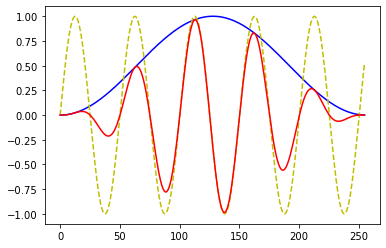

In [3]:
# Hanning window
length = 256
window = signal.get_window('hanning', length)

plt.plot(window, 'b') # Blue
plt.plot(x[:length], 'y--') # Yellow
plt.plot(window * x[:length], 'r') # Red

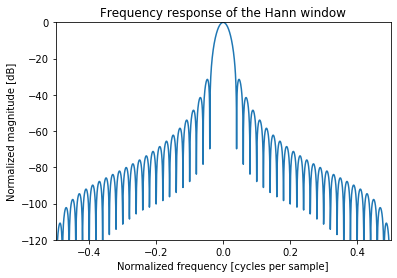

In [4]:
# Plotting Hanning window frequency response
# Taken from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hann.html
window = signal.hann(51)
A = scipy.fft.fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = np.abs(scipy.fft.fftshift(A / abs(A).max()))
response = 20 * np.log10(np.maximum(response, 1e-10))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.show()

### Simple STFT Code Example
Here, we create a longer sine wave, and run the STFT for the first time.

For now, we will just run the STFT with default settings. We will investigate the important parameters later.

In [5]:
# Create basic 440 Hz sine wave
sr = 22050
freq = 440
N = 2 ** 12
x = generate_sine_wave(N, sr, freq)

# Perform STFT
f, t, X = signal.stft(x,                  # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=256,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (after 0-padding, default: nperseg)

# How to get magnitude and phase
magnitude = np.abs(X)
phase = np.angle(X)

### Invertibility
The STFT is also invertible (reversible), if you know the correct window.

All close? True


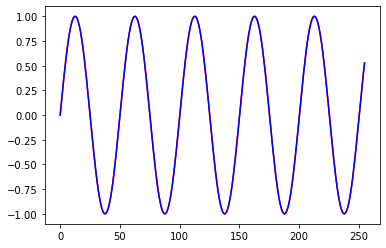

In [6]:
_, x_inverted = signal.istft(X,
                             fs=sr,              # Sample rate (Frequency of Sampling)
                             window='hann')      # Window shape

print("All close? " + str(np.allclose(x, x_inverted)))
plt.plot(x[:256], 'r')
plt.plot(x_inverted[:256], 'b')

## STFT Plotting

This is our basic STFT plotting function. The min/max bounds can be used to zoom in on particular spots in the spectrogram. For now, we will plot our STFT as is, and see how it looks.

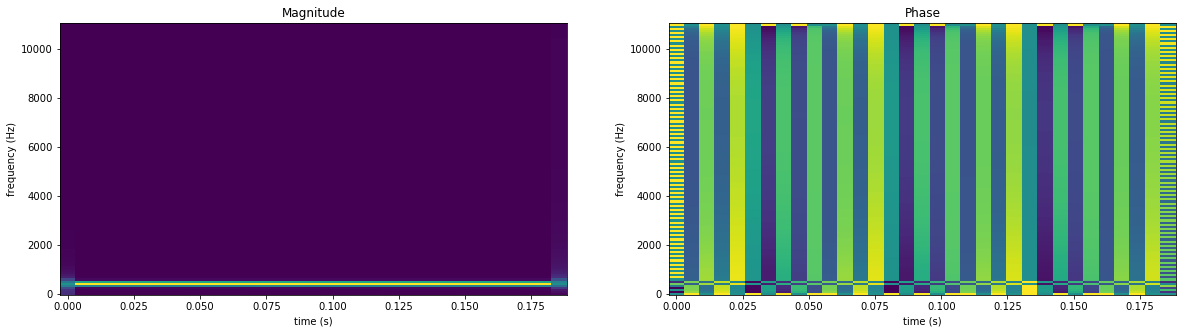

In [7]:
def plot_stft(X, f=None, t=None, f_min=None, f_max=None, t_min=None, t_max=None, log_freq=False, plot_phase=False):
    """
    Plot the phase and magnitude of a given stft result.
    
    Parameters
    ----------
    X : np.ndarray
        The stft result, complex values.
        
    f : np.array
        A list of the frequencies (Hz) corresponding to the first axis of the stft result,
        if known.
        
    t : np.array
        A list of the times (s) corresponding to the second axis of the stft result,
        if known.
        
    f_min : float
        The minimum frequency to be displayed in the plot. This will be clipped to min(f).
        
    f_max : float
        The maximum frequency to be displayed in the plot. This will be clipped to max(f).
        
    t_min : float
        The minimum time to be displayed in the plot. This will be clipped to min(t).
        
    t_max : float
        The maximum time to be displayed in the plot. This will be clipped to max(t).
        
    log_freq : boolean
        Set the frequence axis to log scale.
        
    plot_phase : boolean
        Plot the phase of the spectrogram.
    """
    ###################
    # Parse input
    ###################
    
    # Set up f and t as simple ranges if not given
    f_given = not f is None
    t_given = not t is None
    if f is None:
        f = np.arange(X.shape[0] + 1) - 0.5
    else:
        f = np.append([f[0] - (f[1] - f[0])], f) + ((f[1] - f[0]) / 2)
    if t is None:
        t = np.arange(X.shape[1] + 1) - 0.5
    else:
        t = np.append([t[0] - (t[1] - t[0])], t) + ((t[1] - t[0]) / 2)
    
    
    ##################
    # Get magnitude and phase of result
    ##################
    
    magnitude = np.abs(X)
    phase = np.angle(X)
    
    
    ###################
    # PLOTTING
    ###################
    
    # Create figure
    fig, axs = plt.subplots(1, 2 if plot_phase else 1, figsize=(20,5))
    
    # Plot magnitude
    mag_axis = axs[0] if plot_phase else axs
    mag_axis.pcolormesh(t, f, magnitude)
    mag_axis.set_title("Magnitude")
    mag_axis.set_xlabel(f"time ({'s' if t_given else 'frame'})")
    mag_axis.set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
    mag_axis.set_ylim(f_min, f_max)
    mag_axis.set_xlim(t_min, t_max)
    if log_freq:
        mag_axis.set_yscale('log')
    
    if plot_phase:
        # Plot phase
        axs[1].pcolormesh(t, f, phase)
        axs[1].set_title("Phase")
        axs[1].set_xlabel(f"time ({'s' if t_given else 'frame'})")
        axs[1].set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
        axs[1].set_ylim(f_min, f_max)
        axs[1].set_xlim(t_min, t_max)
        if log_freq:
            axs[1].set_yscale('log')
    
    fig.show()

plot_stft(X, f=f, t=t, plot_phase=True)

### Let's Zoom in on 440 Hz

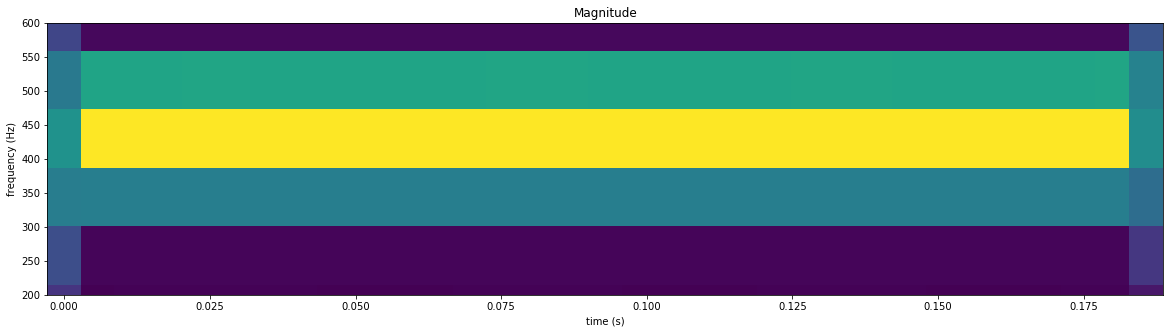

In [8]:
plot_stft(X, f=f, t=t, f_min=200, f_max=600)

We need better frequency resolution! How?
  - Larger window!

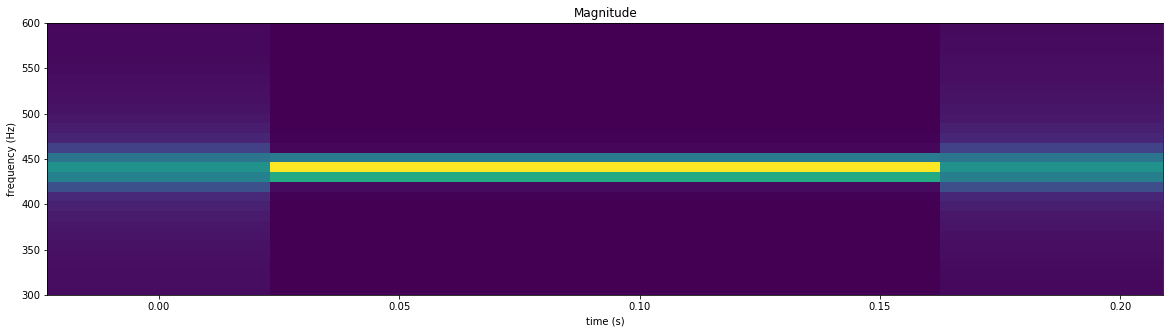

In [9]:
# Basic 440 Hz sine wave
sr = 22050
freq = 440
N = 2 ** 12
x = generate_sine_wave(N, sr, freq)

# Perform STFT
f, t, X = signal.stft(x,                  # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2048,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=300, f_max=600)

Better, but now worse time resolution!

## Let's try with a more complicated signal

In [10]:
# One second chirp
x_upwards = signal.chirp(np.arange(2 * sr) / sr, 220, 2, 880)
x_downwards = signal.chirp(np.arange(2 * sr) / sr, 880, 2, 220)
x_sum = x_upwards + x_downwards

In [11]:
Audio(x_upwards, rate=sr)

In [12]:
Audio(x_downwards, rate=sr)

In [13]:
Audio(x_sum, rate=sr)

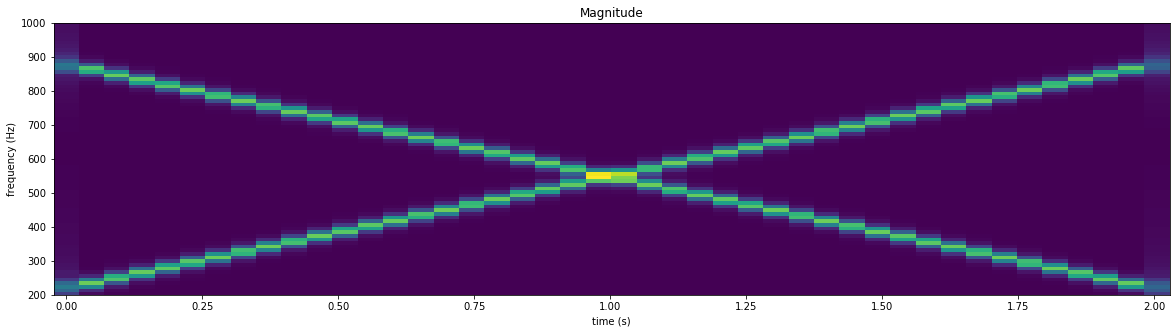

In [14]:
# Perform STFT
f, t, X = signal.stft(x_sum,              # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2056,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=200, f_max=1000)

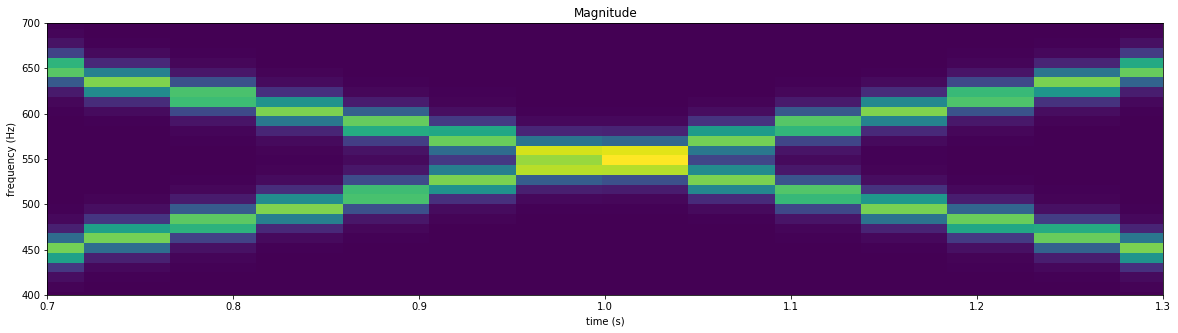

In [15]:
# Perform STFT
f, t, X = signal.stft(x_sum,              # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2048,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=400, f_max=700, t_min=0.7, t_max=1.3)

Mess around with nperseg, noverlap, and nfft above to change the plot. Can you get better time and frequency resolution?

## Additional Notes

* Log-scale frequency benefits.
* Other STFT extensions.

### Log-scale Frequency

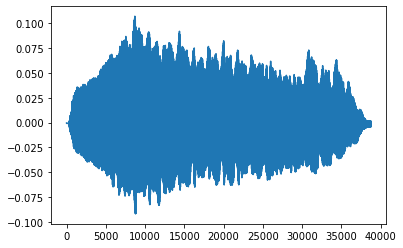

In [16]:
# Violin playing G4
# From: https://www.ee.columbia.edu/~dpwe/sounds/instruments/
sr, x_g4 = scipy.io.wavfile.read('violin-G4.wav')
x_g4 = x_g4 / 32768 # Read as 16-bit integers, rather than floats
plt.plot(x_g4)
Audio(x_g4, rate=sr, normalize=False)


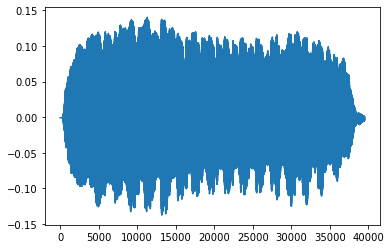

In [17]:
# Violin playing G5
# From: https://www.ee.columbia.edu/~dpwe/sounds/instruments/
sr, x_g5 = scipy.io.wavfile.read('violin-G5.wav')
x_g5 = x_g5 / 32768 # Read as 16-bit integers, rather than floats
plt.plot(x_g5)
Audio(x_g5, rate=sr, normalize=False)

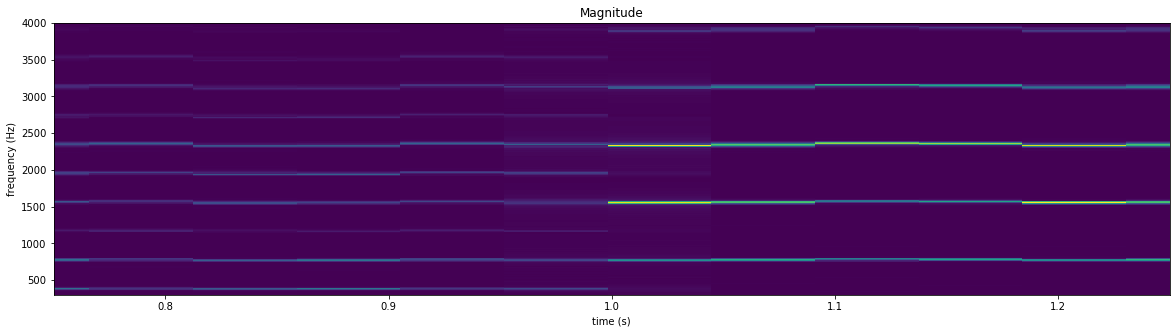

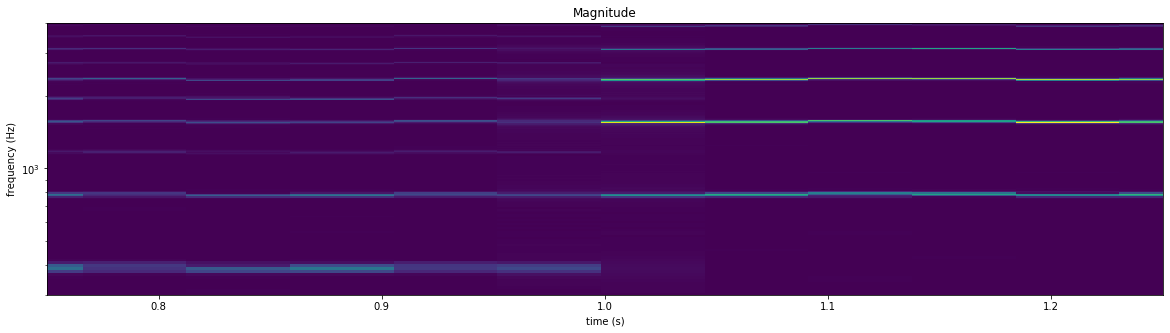

In [18]:
# Append the 2 clips
x = np.append(x_g4[sr:2*sr], x_g5[sr:2*sr])

# Perform STFT
f, t, X = signal.stft(x,                  # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=1024,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=300, f_max=4000, t_min=0.75, t_max=1.25, log_freq=False)
plot_stft(X, f=f, t=t, f_min=300, f_max=4000, t_min=0.75, t_max=1.25, log_freq=True)

Audio(x, rate=sr, normalize=False)

Benefit:
- Allows for each note to look the same, regardless of frequency.

### Constant-Q Transform (CQT)
We will do this with [librosa](https://librosa.github.io/librosa/). Librosa is a package for audio processing specifically designed for music.

A Constant-Q transform uses a different size window depending on the frequency so that the frequency resolution is generally the same no matter what frequency we are looking at.

In [19]:
import librosa

In [20]:
X = librosa.core.cqt(x,
                     sr=sr,
                     hop_length=512,
                     bins_per_octave=12,
                     n_bins=90,
                     fmin=27.5)

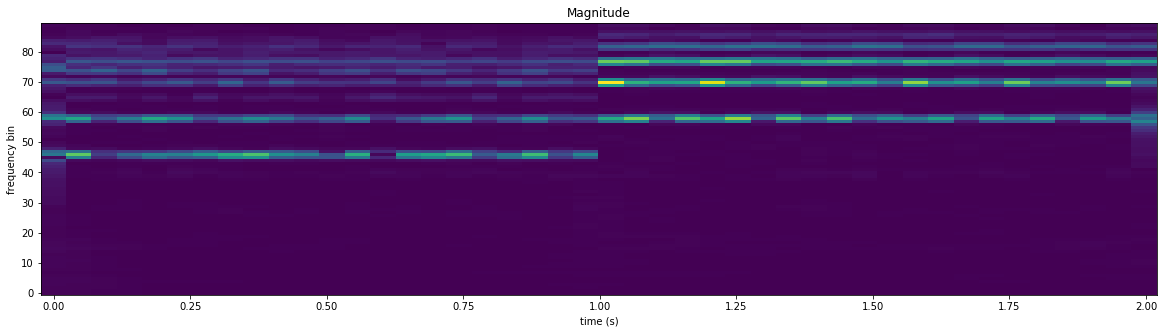

In [21]:
plot_stft(X, t=np.arange(X.shape[1]) / sr * 512)

## Final Thoughts
There are many more ways to get a spectrogram (VQT, MFCC, ...), but they all generally work by tweaking the basic STFT to give you slightly different results, depending on your use case.

* Remember the frequency-time resolution tradeoff in regards to the window length.